<a href="https://colab.research.google.com/github/ericburdett/author-id-network/blob/master/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Author Identification**
#### Eric Burdett

This notebook contains code that can successfully identify authors given a page of handwritten text. The datasets used come from the Missionary Journals dataset that is made available from the BYU library. This work is based off of the following papers:

*   Paper #1
*   Paper #2


##Install PyTorch and Import Dependencies

In [0]:
!pip3 install torch
!pip3 install torchvision
!pip3 install tqdm

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
import torchvision
import os
import gzip
import tarfile
from PIL import Image, ImageOps
import gc
import pdb
from google.colab import drive
drive.mount('/content/drive')
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose',color_scheme='LightBg', tb_offset = 1)

assert torch.cuda.is_available(), "Request a GPU from Runtime > Change Runtime"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Import & Create Missionary Journal Dataset

In [0]:
# Copy the dataset over to colab
!cp "drive/My Drive/datasets/missionary.tar.gz" "/content"

In [2]:
!ls missionary/Ajax_William

0.bmp	 113.bmp  127.bmp  19.bmp  32.bmp  46.bmp  5.bmp   73.bmp  87.bmp
100.bmp  114.bmp  128.bmp  1.bmp   33.bmp  47.bmp  60.bmp  74.bmp  88.bmp
101.bmp  115.bmp  129.bmp  20.bmp  34.bmp  48.bmp  61.bmp  75.bmp  89.bmp
102.bmp  116.bmp  12.bmp   21.bmp  35.bmp  49.bmp  62.bmp  76.bmp  8.bmp
103.bmp  117.bmp  130.bmp  22.bmp  36.bmp  4.bmp   63.bmp  77.bmp  90.bmp
104.bmp  118.bmp  131.bmp  23.bmp  37.bmp  50.bmp  64.bmp  78.bmp  91.bmp
105.bmp  119.bmp  132.bmp  24.bmp  38.bmp  51.bmp  65.bmp  79.bmp  92.bmp
106.bmp  11.bmp   133.bmp  25.bmp  39.bmp  52.bmp  66.bmp  7.bmp   93.bmp
107.bmp  120.bmp  134.bmp  26.bmp  3.bmp   53.bmp  67.bmp  80.bmp  94.bmp
108.bmp  121.bmp  13.bmp   27.bmp  40.bmp  54.bmp  68.bmp  81.bmp  95.bmp
109.bmp  122.bmp  14.bmp   28.bmp  41.bmp  55.bmp  69.bmp  82.bmp  96.bmp
10.bmp	 123.bmp  15.bmp   29.bmp  42.bmp  56.bmp  6.bmp   83.bmp  97.bmp
110.bmp  124.bmp  16.bmp   2.bmp   43.bmp  57.bmp  70.bmp  84.bmp  98.bmp
111.bmp  125.bmp  17.bmp   30.bmp  44.bmp 

In [0]:
!rm missionary/ -r

In [0]:
# Extract into /content/missionary
!tar xzf missionary.tar.gz

In [0]:
class MissionaryDataset(Dataset):
  def __init__(self, size=256):
    if not os.path.exists('/content/missionary'):
      raise Exception('Missionary dataset does not exist in /content/missionary')

    # # Only resize and set dataset_folder once
    # if not os.path.exists(os.path.join('/content/missionary/Ajax_William/0.bmp')):
    #   self.resize('/content/missionary', size)
    
    self.dataset_folder = torchvision.datasets.ImageFolder('/content/missionary',
        transform=transforms.Compose([transforms.ToTensor()]))

  def num_classes(self):
    return len(self.dataset_folder.class_to_idx)

  def resize(self, path, size):
    """Resizes all images in place"""
    print("Resizing images")
    dirs = os.walk(path)
    for root, dirs, files in os.walk(path):
        for item in files:
            name = os.path.join(root, item)
            if os.path.isfile(name):
                im = Image.open(name)
                im = ImageOps.fit(im, (size, size))
                im.save(name[:-3] + 'bmp', 'BMP')
                os.remove(name)

  def idx_to_class(self, idx):
    for key, value in self.dataset_folder.class_to_idx.items():
      if value == idx:
        return key
    
    raise Exception('Class not found for index ' + idx)

  def __getitem__(self, index):
    return self.dataset_folder[index]

  def __len__(self):
    return len(self.dataset_folder)

In [40]:
dataset = MissionaryDataset()
dataset.__getitem__(0)[1]

0

##Create our model using a CNN

In [0]:
class AuthorIdNetwork(nn.Module):
  def __init__(self, dataset):
    super(AuthorIdNetwork, self).__init__()

    x, y = dataset[0]
    in_channels, height, width = x.size()

    num_classes = dataset.num_classes()

    CONV1_CHANNELS = 96
    CONV1_SIZE = (5, 5)
    CONV1_STRIDE = 1
    CONV1_PADDING = 2
    CONV2_5_CHANNELS = 256 
    CONV2_5_SIZE = (3, 3)
    CONV2_5_STRIDE = 1
    CONV2_5_PADDING = 1
    CONV3_4_CHANNELS = 384
    CONV3_4_SIZE = (3, 3)
    CONV3_4_STRIDE = 1
    CONV3_4_PADDING = 1
    FC_COUNT = 1024
    self.fc_input = CONV2_5_CHANNELS * (height // 8) * (width // 8)

    MP_SIZE= (3, 3)
    MP_STRIDE = 2
    MP_PADDING = 1

    self.conv1 = nn.Conv2d(in_channels, CONV1_CHANNELS, CONV1_SIZE, stride=CONV1_STRIDE, padding=CONV1_PADDING)
    self.relu1 = nn.ReLU()
    self.mp1 = nn.MaxPool2d(MP_SIZE, stride=MP_STRIDE, padding=MP_PADDING)
    self.conv2 = nn.Conv2d(CONV1_CHANNELS, CONV2_5_CHANNELS, CONV2_5_SIZE, stride=CONV2_5_STRIDE, padding=CONV2_5_PADDING)
    self.relu2 = nn.ReLU()
    self.mp2 =  nn.MaxPool2d(MP_SIZE, stride=MP_STRIDE, padding=MP_PADDING)
    self.conv3 = nn.Conv2d(CONV2_5_CHANNELS, CONV3_4_CHANNELS, CONV3_4_SIZE, stride=CONV3_4_STRIDE, padding=CONV3_4_PADDING)
    self.relu3 = nn.ReLU()
    self.conv4 = nn.Conv2d(CONV3_4_CHANNELS, CONV3_4_CHANNELS, CONV3_4_SIZE, stride=CONV3_4_STRIDE, padding=CONV3_4_PADDING)
    self.relu4 = nn.ReLU()
    self.conv5 = nn.Conv2d(CONV3_4_CHANNELS, CONV2_5_CHANNELS, CONV2_5_SIZE, stride=CONV2_5_STRIDE, padding=CONV2_5_PADDING)
    self.relu5 = nn.ReLU()
    self.mp3 = nn.MaxPool2d(MP_SIZE, stride=MP_STRIDE, padding=MP_PADDING)
    self.fc1 = nn.Linear(self.fc_input, FC_COUNT, bias=True)
    self.relu6 = nn.ReLU()
    self.fc2 = nn.Linear(FC_COUNT, num_classes, bias=True)
    self.relu7 = nn.ReLU()
    # self.drop = nn.Dropout(p=0.5)
    self.soft = nn.Softmax(dim=0)

  def forward(self, x):
    batch_size = x.shape[0]

    conv1_out = self.conv1(x)
    # print('conv1_out:', conv1_out.shape)
    relu1_out = self.relu1(conv1_out)
    mp1_out = self.mp1(relu1_out)
    # print('mp1_out:', mp1_out.shape)
    conv2_out = self.conv2(mp1_out)
    # print('conv2_out:', conv2_out.shape)
    relu2_out = self.relu2(conv2_out)
    mp2_out = self.mp2(relu2_out)
    # print('mp2_out:', mp2_out.shape)
    conv3_out = self.conv3(mp2_out)
    # print('conv3_out:', conv3_out.shape)
    relu3_out = self.relu3(conv3_out)
    conv4_out = self.conv4(relu3_out)
    # print('conv4_out:', conv4_out.shape)
    relu4_out = self.relu4(conv4_out)
    conv5_out = self.conv5(relu4_out)
    # print('conv5_out:', conv5_out.shape)
    relu5_out = self.relu5(conv5_out)
    mp3_out = self.mp3(relu5_out)
    # print('mp3_out:', mp3_out.shape)
    mp3_out_viewed = mp3_out.view(batch_size, self.fc_input)
    fc1_out = self.fc1(mp3_out_viewed)
    # print('fc1_out:', fc1_out.shape)
    relu6_out = self.relu6(fc1_out)
    fc2_out = self.fc2(relu6_out)
    # print('fc2_out:', fc2_out.shape)
    relu7_out = self.relu7(fc2_out)
    # drop_out = self.drop(relu7_out)
    # print('drop_out:', drop_out.shape)
    soft_out = self.soft(relu7_out)
    # print('soft_out:', soft_out.shape)

    return soft_out

##Training

In [0]:
def train():
  NUM_EPOCHS = 1
  BATCH_SIZE = 50

  dataset = MissionaryDataset()
  train_dataset, val_dataset = torch.utils.data.random_split(dataset, [int(.8 * len(dataset)), int(.2 * len(dataset))])

  model = AuthorIdNetwork(dataset)
  model = model.cuda()

  objective = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=1e-3)

  train_loader = DataLoader(train_dataset,
                            batch_size=BATCH_SIZE,
                            num_workers=4,
                            pin_memory=True,
                            shuffle=True)
  
  val_loader = DataLoader(val_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=4,
                          pin_memory=True,
                          shuffle=True)
  
  train_losses = []
  val_losses = []
  train_accs = []
  val_accs = []

  for epoch in range(NUM_EPOCHS):
    loop = tqdm(total=len(train_loader), position=0, leave=False)

    for batch, (x, y_truth) in enumerate(train_loader):
      gc.collect()
      x, y_truth = x.cuda(async=True), y_truth.cuda(async=True)

      optimizer.zero_grad()
      y_hat = model(x)

      accuracy = torch.eq(y_hat.argmax(1), y_truth.long()).float().mean()
      loss = objective(y_hat, y_truth.long())

      loss.backward()

      train_losses.append(loss.item())
      train_accs.append(accuracy.item())

      loop.set_description('epoch:{}, loss:{:.4f}, acc:{:.4f}, avgloss:{:.4f}, avgacc:{:.4f}'.format(epoch, loss.item(), accuracy.item(),np.mean(train_losses), np.mean(train_accs)))
      loop.update(1)

      optimizer.step()

      # if batch % 10 == 0:
      #   gc.collect()

      #   val_single_acc = []
      #   val_single_loss = []

      #   for _, (val_x, val_y_truth) in enumerate(val_loader):
      #     gc.collect()
      #     val_x, val_y_truth = val_x.cuda(), val_y_truth.cuda().long()


      #     val_y_hat = model(val_x)

      #     val_accuracy = torch.eq(val_y_hat.argmax(1), val_y_truth)
      #     val_loss = objective(val_y_hat, val_y_truth)

      #     val_single_acc.append(val_accuracy)
      #     val_single_loss.append(val_loss)

      #   val_accs.append(val_single_acc)
      #   val_losses.append(val_single_loss)
    
    loop.close()

  return model, train_losses, val_losses, train_accs, val_accs

try:
  model, train_losses, val_losses, train_accs, val_accs = train()
  gc.collect()
except:
  gc.collect()
  __ITB__()

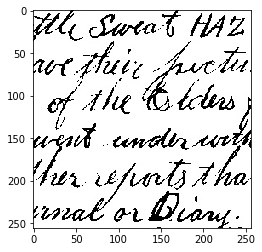

In [33]:
dataset = MissionaryDataset()
img = dataset.__getitem__(9000)
plt.imshow(img[0].permute(1,2,0))

##Results

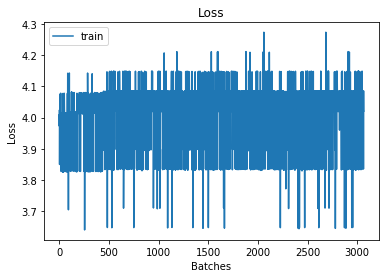

In [8]:
# Plot the Loss
# a, b = zip(*val_losses)
plt.title('Loss')
plt.xlabel('Batches')
plt.ylabel('Loss')
plt.plot(train_losses, label='train')
# plt.plot(a, b, label='val')
plt.legend()
plt.show()

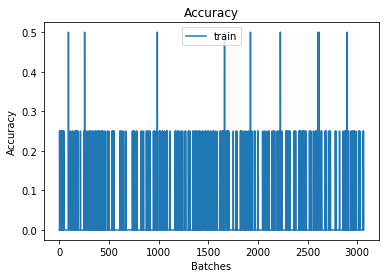

In [11]:
# Plot the Accuracy
plt.title('Accuracy')
plt.xlabel('Batches')
plt.ylabel('Accuracy')
# a, b = zip(*val_accs)
plt.plot(train_accs, label='train')
# plt.plot(a, b, label='val')
plt.legend()
plt.show()

##Conclusion

The above CNN architecture achieves...

These are the contributions and performance of the model...